## This notebook shows the implementation of different conv-based strategies (ranging from data augmentation to the use of pre-trained models) to develop a classifier of dogs and cats images.

First, let's setup the working directory and split the data into subdirectories for better organization. I'm using my local Downloads folder for this.

In [4]:
import os, shutil

original_dataset_dir = '/Users/Andres/Downloads/kaggle_original_data/train'
base_dir = '/Users/Andres/Downloads/cats_and_dogs_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]

for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Let's do a sanity check to see if everything was splitted up as expected.

In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

print('\ntotal training dog images:', len(os.listdir(train_dogs_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total test cat images: 500
total validation cat images: 500

total training dog images: 1000
total test dog images: 500
total validation dog images: 500


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

Now let's construct neural net using a combination of conv2d and maxpooling layers.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Definition of loss function, optimizer and evaluation metrics:

In [7]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

We will be feeding the images to the model in batches using a generator of the rescaled images. Thankfully TF has us covered with it's ImageDateGenerator object.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
    
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
from PIL import Image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit the model:

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 22s 224ms/step - loss: 0.6883 - acc: 0.5430 - val_loss: 0.6902 - val_acc: 0.5290
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6482 - acc: 0.6240 - val_loss: 0.6375 - val_acc: 0.6170
Epoch 3/30
100/100 [==============================] - 8s 83ms/step - loss: 0.6001 - acc: 0.6920 - val_loss: 0.6124 - val_acc: 0.6630
Epoch 4/30
100/100 [==============================] - 8s 78ms/step - loss: 0.5574 - acc: 0.7180 - val_loss: 0.5831 - val_acc: 0.6880
Epoch 5/30
100/100 [==============================] - 8s 81ms/step - loss: 0.5242 - acc: 0.7410 - val_loss: 0.6080 - val_acc: 0.6720
Epoch 6/30
100/100 [==============================] - 8s 83ms/step - loss: 0.5007 - acc: 0.7575 - val_loss: 0.5562 - val_acc: 0.7150
Epoch 7/30
100/100 [==============================] - 8s 83ms/step - loss: 0.4813 - acc: 0.7655 - val_loss: 0.6031 - val_acc: 0.6930
Epoch 8/30
100/100 

In [12]:
#Better to save the model in case it is needed later since the training is slow
model.save('cats_and_dogs_small_1.h5')

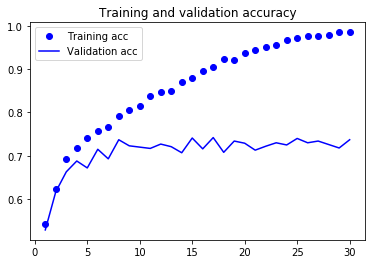

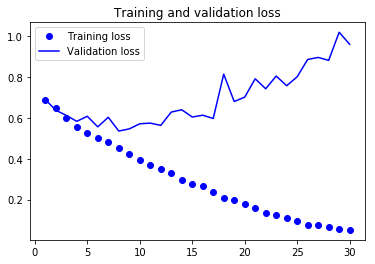

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We are definitively experiencing some overfitting. Let's try to fix this using a Data Augmentation strategy:

In [15]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

Let's see what the data augmentation is doing to the images:

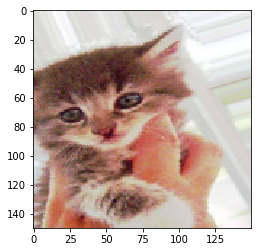

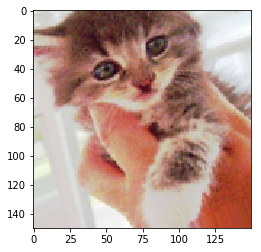

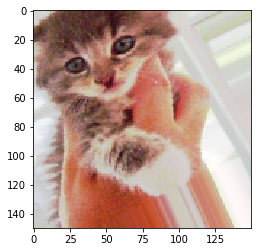

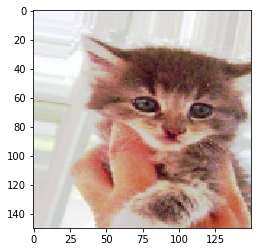

In [19]:
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
fname in os.listdir(train_cats_dir)]
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()


Since we are experiencing overfitting it may also be a good idea to add a Dropout layer to our conv net:

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's fit the new model with the augmented dataset:

In [22]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
63/63 [==============================] - 18s 280ms/step - loss: 0.6965 - acc: 0.5060 - val_loss: 0.6881 - val_acc: 0.5820
Epoch 2/100
63/63 [==============================] - 15s 245ms/step - loss: 0.6869 - acc: 0.5370 - val_loss: 0.6796 - val_acc: 0.5780
Epoch 3/100
63/63 [==============================] - 15s 245ms/step - loss: 0.6782 - acc: 0.5705 - val_loss: 0.6680 - val_acc: 0.5630
Epoch 4/100
63/63 [==============================] - 15s 245ms/step - loss: 0.6709 - acc: 0.5790 - val_loss: 0.6552 - val_acc: 0.5970
Epoch 5/100
63/63 [==============================] - 14s 227ms/step - loss: 0.6674 - acc: 0.5820 - val_loss: 0.7022 - val_acc: 0.5200
Epoch 6/100
63/63 [==============================] - 17s 277ms/step - loss: 0.6498 - acc: 0.6195 - val_loss: 0.6239 - val_acc: 0.6400
Epoch 7/100
63/63 [==============================] - 18s 285ms/step - loss: 0.6472 - acc: 0.6215 - val_loss: 0.6114 - val_acc: 0.6630
Epoch 8/100
63/63 [==============================] - 17s 276ms

Epoch 38/100
63/63 [==============================] - 14s 230ms/step - loss: 0.5139 - acc: 0.7525 - val_loss: 0.4902 - val_acc: 0.7570
Epoch 39/100
63/63 [==============================] - 14s 229ms/step - loss: 0.4937 - acc: 0.7535 - val_loss: 0.5040 - val_acc: 0.7450
Epoch 40/100
63/63 [==============================] - 14s 228ms/step - loss: 0.5083 - acc: 0.7400 - val_loss: 0.5142 - val_acc: 0.7510
Epoch 41/100
63/63 [==============================] - 14s 228ms/step - loss: 0.5037 - acc: 0.7530 - val_loss: 0.5095 - val_acc: 0.7550
Epoch 42/100
63/63 [==============================] - 15s 231ms/step - loss: 0.5024 - acc: 0.7580 - val_loss: 0.5337 - val_acc: 0.7390
Epoch 43/100
63/63 [==============================] - 14s 230ms/step - loss: 0.4990 - acc: 0.7675 - val_loss: 0.4824 - val_acc: 0.7650
Epoch 44/100
63/63 [==============================] - 14s 227ms/step - loss: 0.5091 - acc: 0.7545 - val_loss: 0.4788 - val_acc: 0.7740
Epoch 45/100
63/63 [==============================] - 1

In [23]:
#And save it again, just in case
model.save('cats_and_dogs_small_2.h5')

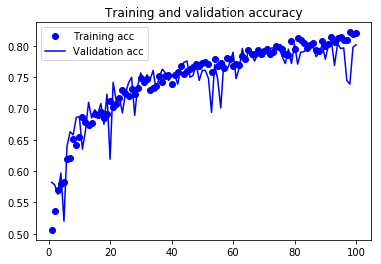

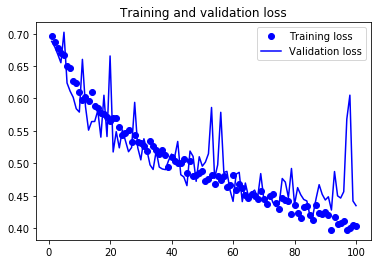

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### By applying data augmentation and a regularization technique via the dropout layer we have successfully mitigated the effects of overfitting.

Let's try a new approach, using a pretrained conv net:

In [25]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 22s 0us/step


For training, first we'll use a CPU-friendly approach. We'll run the conv base once for every image and save its output to a numpy array on disk. Then use this data as input for a vanilla DNN. It is a fast solution but won't allow data augmentation:

In [29]:
import numpy as np

base_dir = '/Users/Andres/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

Instantiate the sequential model, compile and train it:

In [32]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
        loss='binary_crossentropy',
        metrics=['acc'])
        history = model.fit(train_features, train_labels,
        epochs=30,
        batch_size=20,
        validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 953us/sample - loss: 0.5929 - acc: 0.6780 - val_loss: 0.4561 - val_acc: 0.8200
Epoch 2/30
2000/2000 [==============================] - 1s 378us/sample - loss: 0.4356 - acc: 0.8045 - val_loss: 0.3857 - val_acc: 0.8320
Epoch 3/30
2000/2000 [==============================] - 1s 374us/sample - loss: 0.3587 - acc: 0.8450 - val_loss: 0.3307 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 436us/sample - loss: 0.3274 - acc: 0.8635 - val_loss: 0.3068 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 1s 370us/sample - loss: 0.2961 - acc: 0.8850 - val_loss: 0.2903 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 1s 382us/sample - loss: 0.2632 - acc: 0.8985 - val_loss: 0.2782 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 1s 385us/sample - loss: 0.2523 - acc: 0.9010 - val_loss: 0.2718 - va

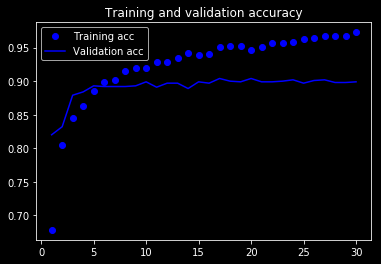

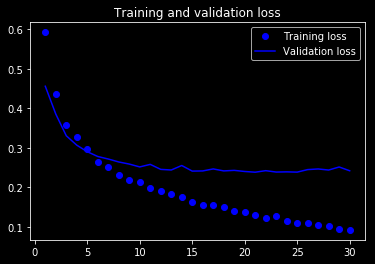

In [35]:
plt.style.use('dark_background')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Using this strategy we have achieved a better accuracy than with previous ones. However we are experiencing overfitting again. It was expected since we did not use data augmentation. The dropout wasn't enough and we need a more robust regularization strategy.

Now let's use try something different (GPU needed for training).
Let's extend the conv_base model by appending the dense layers on top of it and running the complete model. Now we can use data augmentation:

In [36]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

It is important to freeze the conv base so we don't relearn its parameters:

In [37]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


Let's setup, compile and train the model:

In [38]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 23s 233ms/step - loss: 0.5991 - acc: 0.6865 - val_loss: 0.4676 - val_acc: 0.8010
Epoch 2/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4822 - acc: 0.7895 - val_loss: 0.3766 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4367 - acc: 0.8070 - val_loss: 0.3351 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 23s 227ms/step - loss: 0.4029 - acc: 0.8305 - val_loss: 0.3100 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 23s 227ms/step - loss: 0.3917 - acc: 0.8155 - val_loss: 0.2930 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 23s 227ms/step - loss: 0.3677 - acc: 0.8435 - val_loss: 0.2796 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 23s 227ms/step - loss: 0.3540 - acc: 0.8500 - val_lo

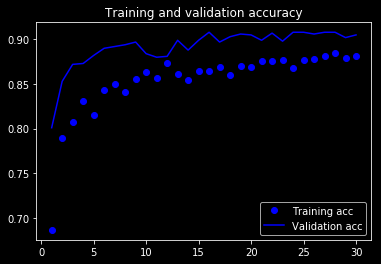

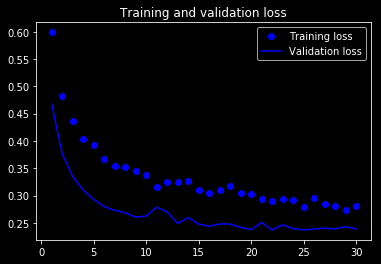

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We've succesfully mitigated the effect of overfitting using data augmentation at the cost of a GPU-only strategy.